In [133]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates


import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.gnn import create_features, create_label
from spektral.layers import GCNConv
from spektral.utils import gcn_filter

In [134]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
id_column = "WHO_region"
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column, id_column])[target_column].sum().reset_index()
unique_dates = df[date_column].unique()
um_countries_regions = len(df[id_column].unique())
df.head()

,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [135]:
# pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

df.rename(columns={"index": date_column}, inplace=True)
df.head()


,Date_reported,WHO_region,New_deaths
0,2020-02-02,AFRO,49.0
1,2020-02-02,AMRO,56.0
2,2020-02-02,EMRO,22.0
3,2020-02-02,EURO,65.0
4,2020-02-02,Other,1.0


In [136]:
unstaked_df = df.copy()
unstaked_df["id"] = unstaked_df["WHO_region"]
unstaked_df.set_index(["id", "Date_reported"], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop(["WHO_region"], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, :15].head()

(7, 1390)


Date_reported,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16
id,,,,,,,,,,,,,,,
AFRO,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0,49.0
AMRO,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0,56.0
EMRO,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0
EURO,65.0,62.0,63.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,63.0
Other,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [137]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 14

In [138]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[int(len(unique_dates) *0.8)+1]
test_date = unique_dates[int(len(unique_dates) *0.9)]

In [139]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date + timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_train_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_train_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_train_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_train = np.concatenate(y, axis=0).astype("float16")

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

  0%|          | 0/1100 [00:00<?, ?it/s]/home/samuell/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/samuell/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/samuell/Desktop/timeseries-forecasting/shared/gnn.py:26: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(group_store, axis=2),
/home/samuell/Desktop/timeseries-forecasting/shared/gnn.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(group_store, axis=2),
  4%|▍         | 49/1100 [00:00<00:08, 120.85it/s]

100%|██████████| 1100/1100 [00:08<00:00, 127.18it/s]


(1100, 14, 7) (1100, 7, 7) (1100, 7, 7) (1100, 7)


In [140]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date + timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_valid_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_valid_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_valid_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_valid = np.concatenate(y, axis=0).astype("float16")

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)

100%|██████████| 125/125 [00:00<00:00, 146.82it/s]

(125, 14, 7) (125, 7, 7) (125, 7, 7) (125, 7)


In [141]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(
    pd.date_range(test_date + timedelta(days=sequence_length), unique_dates[-1])
):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length, um_countries_regions)
    y_ = create_label(unstaked_df, d, um_countries_regions)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)

X_test_seq = np.concatenate(X_seq, axis=0).astype("float16")
X_test_cor = np.concatenate(X_cor, axis=0).astype("float16")
X_test_feat = np.concatenate(X_feat, axis=0).astype("float16")
y_test = np.concatenate(y, axis=0).astype("float16")

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 125/125 [00:01<00:00, 122.42it/s]


(125, 14, 7) (125, 7, 7) (125, 7, 7) (125, 7)


In [142]:
X_train_lap = gcn_filter(1 - np.abs(X_train_cor))
X_valid_lap = gcn_filter(1 - np.abs(X_valid_cor))
X_test_lap = gcn_filter(1 - np.abs(X_test_cor))

In [143]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model():
    set_seed(33)

    opt = Adam(lr=15)

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GCNConv(256, activation="relu")([inp_feat, inp_lap])
    x = GCNConv(128, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(256, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(128, activation="relu")(xx)

    x = Concatenate()([x, xx])
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.1)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [144]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###
import pickle
pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)
models = []
model_files = []
for region in range(um_countries_regions):
    print("-------", "region", region, "-------")

    es = EarlyStopping(
        patience=5,
        verbose=1,
        min_delta=5,
        monitor="val_loss",
        mode="auto",
        restore_best_weights=True,
    )

    opt = Adam(lr=15)

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GCNConv(256, activation="relu")([inp_feat, inp_lap])
    x = GCNConv(128, activation="relu")([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(256, activation="relu", return_sequences=True)(inp_seq)
    xx = LSTM(128, activation="relu")(xx)

    x = Concatenate()([x, xx])
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.1)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(
        optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    model.fit(
        [X_train_seq, X_train_lap, X_train_feat],
        y_train[:, region],
        epochs=1000,
        batch_size=30,
        validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:, region]),
        callbacks=[es],
        verbose=2,
    )
    model.save(f"../stored_models/gnn/gnn_{region}.h5")
    model_files.append(f"gnn_{region}")
    models.append(model)


------- region 0 -------
Epoch 1/1000
37/37 - 9s - loss: 79049.5703 - root_mean_squared_error: 281.1576 - val_loss: 2422.5464 - val_root_mean_squared_error: 49.2194 - 9s/epoch - 235ms/step
Epoch 2/1000
37/37 - 2s - loss: 79041.6172 - root_mean_squared_error: 281.1434 - val_loss: 2418.9282 - val_root_mean_squared_error: 49.1826 - 2s/epoch - 54ms/step
Epoch 3/1000
37/37 - 3s - loss: 79026.6484 - root_mean_squared_error: 281.1168 - val_loss: 2415.3403 - val_root_mean_squared_error: 49.1461 - 3s/epoch - 72ms/step
Epoch 4/1000
37/37 - 2s - loss: 79011.6875 - root_mean_squared_error: 281.0902 - val_loss: 2411.7944 - val_root_mean_squared_error: 49.1100 - 2s/epoch - 66ms/step
Epoch 5/1000
37/37 - 2s - loss: 78996.8672 - root_mean_squared_error: 281.0638 - val_loss: 2408.1887 - val_root_mean_squared_error: 49.0733 - 2s/epoch - 58ms/step
Epoch 6/1000
37/37 - 2s - loss: 78981.9453 - root_mean_squared_error: 281.0373 - val_loss: 2404.6125 - val_root_mean_squared_error: 49.0368 - 2s/epoch - 64ms/s

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


------- region 1 -------
Epoch 1/1000
37/37 - 8s - loss: 11270391.0000 - root_mean_squared_error: 3357.1404 - val_loss: 116003.3516 - val_root_mean_squared_error: 340.5927 - 8s/epoch - 213ms/step
Epoch 2/1000
37/37 - 2s - loss: 11271352.0000 - root_mean_squared_error: 3357.2834 - val_loss: 115935.8828 - val_root_mean_squared_error: 340.4936 - 2s/epoch - 66ms/step
Epoch 3/1000
37/37 - 2s - loss: 11270119.0000 - root_mean_squared_error: 3357.0999 - val_loss: 115857.5781 - val_root_mean_squared_error: 340.3786 - 2s/epoch - 48ms/step
Epoch 4/1000
37/37 - 2s - loss: 11268608.0000 - root_mean_squared_error: 3356.8748 - val_loss: 115759.2656 - val_root_mean_squared_error: 340.2341 - 2s/epoch - 67ms/step
Epoch 5/1000
37/37 - 2s - loss: 11266675.0000 - root_mean_squared_error: 3356.5869 - val_loss: 115632.1328 - val_root_mean_squared_error: 340.0472 - 2s/epoch - 57ms/step
Epoch 6/1000
37/37 - 2s - loss: 11264230.0000 - root_mean_squared_error: 3356.2227 - val_loss: 115468.3203 - val_root_mean_s

------- region 2 -------
Epoch 1/1000
37/37 - 8s - loss: 195619.2188 - root_mean_squared_error: 442.2886 - val_loss: 736.3765 - val_root_mean_squared_error: 27.1363 - 8s/epoch - 228ms/step
Epoch 2/1000
37/37 - 3s - loss: 195479.0312 - root_mean_squared_error: 442.1301 - val_loss: 727.0121 - val_root_mean_squared_error: 26.9632 - 3s/epoch - 73ms/step
Epoch 3/1000
37/37 - 2s - loss: 195341.6875 - root_mean_squared_error: 441.9748 - val_loss: 715.7668 - val_root_mean_squared_error: 26.7538 - 2s/epoch - 53ms/step
Epoch 4/1000
37/37 - 3s - loss: 195166.4219 - root_mean_squared_error: 441.7764 - val_loss: 701.3035 - val_root_mean_squared_error: 26.4821 - 3s/epoch - 73ms/step
Epoch 5/1000
37/37 - 2s - loss: 194933.6094 - root_mean_squared_error: 441.5129 - val_loss: 681.9269 - val_root_mean_squared_error: 26.1137 - 2s/epoch - 48ms/step
Epoch 6/1000
37/37 - 3s - loss: 194628.1250 - root_mean_squared_error: 441.1668 - val_loss: 656.9401 - val_root_mean_squared_error: 25.6308 - 3s/epoch - 73ms/s

------- region 3 -------
Epoch 1/1000
37/37 - 9s - loss: 11515092.0000 - root_mean_squared_error: 3393.3894 - val_loss: 24543.4688 - val_root_mean_squared_error: 156.6636 - 9s/epoch - 242ms/step
Epoch 2/1000
37/37 - 2s - loss: 11514182.0000 - root_mean_squared_error: 3393.2554 - val_loss: 24497.8730 - val_root_mean_squared_error: 156.5180 - 2s/epoch - 64ms/step
Epoch 3/1000
37/37 - 2s - loss: 11513481.0000 - root_mean_squared_error: 3393.1521 - val_loss: 24443.3066 - val_root_mean_squared_error: 156.3436 - 2s/epoch - 56ms/step
Epoch 4/1000
37/37 - 2s - loss: 11512611.0000 - root_mean_squared_error: 3393.0239 - val_loss: 24373.3145 - val_root_mean_squared_error: 156.1196 - 2s/epoch - 64ms/step
Epoch 5/1000
37/37 - 2s - loss: 11511465.0000 - root_mean_squared_error: 3392.8550 - val_loss: 24283.5801 - val_root_mean_squared_error: 155.8319 - 2s/epoch - 62ms/step
Epoch 6/1000
37/37 - 2s - loss: 11509967.0000 - root_mean_squared_error: 3392.6343 - val_loss: 24161.2305 - val_root_mean_squared

------- region 4 -------
Epoch 1/1000
37/37 - 9s - loss: 50.6797 - root_mean_squared_error: 7.1190 - val_loss: 0.8609 - val_root_mean_squared_error: 0.9279 - 9s/epoch - 243ms/step
Epoch 2/1000
37/37 - 2s - loss: 0.8286 - root_mean_squared_error: 0.9103 - val_loss: 0.7167 - val_root_mean_squared_error: 0.8466 - 2s/epoch - 54ms/step
Epoch 3/1000
37/37 - 2s - loss: 0.6832 - root_mean_squared_error: 0.8265 - val_loss: 0.5777 - val_root_mean_squared_error: 0.7601 - 2s/epoch - 63ms/step
Epoch 4/1000
37/37 - 2s - loss: 0.5497 - root_mean_squared_error: 0.7414 - val_loss: 0.4543 - val_root_mean_squared_error: 0.6740 - 2s/epoch - 61ms/step
Epoch 5/1000
37/37 - 2s - loss: 0.4336 - root_mean_squared_error: 0.6585 - val_loss: 0.3498 - val_root_mean_squared_error: 0.5915 - 2s/epoch - 57ms/step
Epoch 6/1000
Restoring model weights from the end of the best epoch: 1.
37/37 - 2s - loss: 0.3370 - root_mean_squared_error: 0.5805 - val_loss: 0.2639 - val_root_mean_squared_error: 0.5137 - 2s/epoch - 63ms/s

------- region 5 -------
Epoch 1/1000
37/37 - 11s - loss: 1562887.6250 - root_mean_squared_error: 1250.1550 - val_loss: 13022.6240 - val_root_mean_squared_error: 114.1167 - 11s/epoch - 291ms/step
Epoch 2/1000
37/37 - 2s - loss: 1562609.7500 - root_mean_squared_error: 1250.0439 - val_loss: 13015.8613 - val_root_mean_squared_error: 114.0871 - 2s/epoch - 55ms/step
Epoch 3/1000
37/37 - 2s - loss: 1562344.1250 - root_mean_squared_error: 1249.9376 - val_loss: 13006.1836 - val_root_mean_squared_error: 114.0447 - 2s/epoch - 67ms/step
Epoch 4/1000
37/37 - 2s - loss: 1561961.3750 - root_mean_squared_error: 1249.7845 - val_loss: 12992.2080 - val_root_mean_squared_error: 113.9834 - 2s/epoch - 53ms/step
Epoch 5/1000
37/37 - 2s - loss: 1561401.5000 - root_mean_squared_error: 1249.5605 - val_loss: 12972.1055 - val_root_mean_squared_error: 113.8951 - 2s/epoch - 68ms/step
Epoch 6/1000
37/37 - 2s - loss: 1560629.1250 - root_mean_squared_error: 1249.2515 - val_loss: 12946.2168 - val_root_mean_squared_err

------- region 6 -------
Epoch 1/1000
37/37 - 8s - loss: 479674.5312 - root_mean_squared_error: 692.5854 - val_loss: 5743.9868 - val_root_mean_squared_error: 75.7891 - 8s/epoch - 222ms/step
Epoch 2/1000
37/37 - 2s - loss: 479584.9375 - root_mean_squared_error: 692.5207 - val_loss: 5740.0308 - val_root_mean_squared_error: 75.7630 - 2s/epoch - 53ms/step
Epoch 3/1000
37/37 - 3s - loss: 479559.2812 - root_mean_squared_error: 692.5022 - val_loss: 5736.1426 - val_root_mean_squared_error: 75.7373 - 3s/epoch - 69ms/step
Epoch 4/1000
37/37 - 2s - loss: 479533.5000 - root_mean_squared_error: 692.4836 - val_loss: 5732.1987 - val_root_mean_squared_error: 75.7113 - 2s/epoch - 61ms/step
Epoch 5/1000
37/37 - 2s - loss: 479507.7812 - root_mean_squared_error: 692.4650 - val_loss: 5728.2129 - val_root_mean_squared_error: 75.6850 - 2s/epoch - 65ms/step
Epoch 6/1000
37/37 - 2s - loss: 479482.0312 - root_mean_squared_error: 692.4464 - val_loss: 5724.2930 - val_root_mean_squared_error: 75.6591 - 2s/epoch - 

In [145]:
for region, model in enumerate(models):

    pred_valid_all[:, region] = model.predict(
        [X_valid_seq, X_valid_lap, X_valid_feat]
    ).ravel()
    pred_test_all[:, region] = model.predict(
        [X_test_seq, X_test_lap, X_test_feat]
    ).ravel()



reverse_valid = y_valid
reverse_test = y_test

4/4 [==============================] - 0s 24ms/step


In [146]:
def plot_predictions(y_true, y_pred, store, item):
    y_true = y_true.reshape(1, -1, 7)
    y_pred = y_pred.reshape(1, -1, 7)
    t = y_true[item, :, store]
    for i in range(7):

        plt.plot(y_true[item, :, store], label="true")
        plt.plot(y_pred[item, :, store], label="prediction")
        plt.title(f"store: {store} item: {item}")
        plt.legend()
        plt.ylabel("sales")
        plt.xlabel("date")

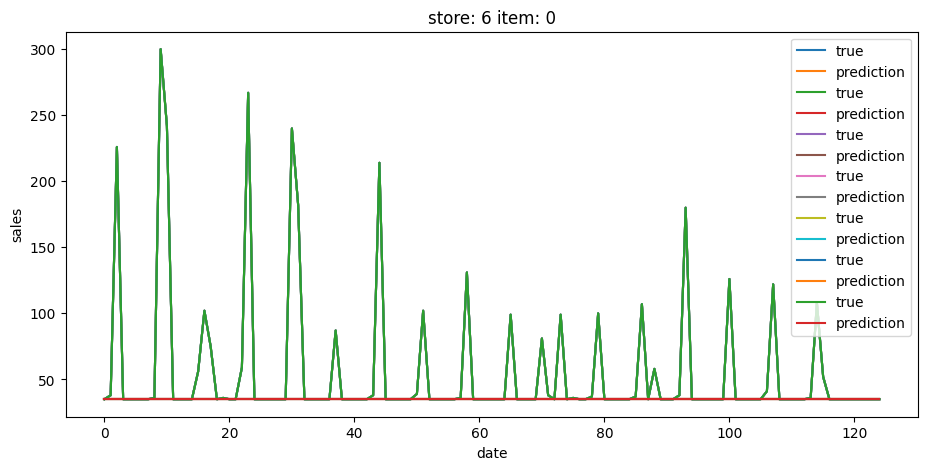

In [147]:
plt.figure(figsize=(11, 5))
plot_predictions(reverse_test, pred_test_all, 6, 0)

In [148]:
y_true = np.sum(reverse_test, axis=1)
pred = np.sum(pred_test_all, axis=1)


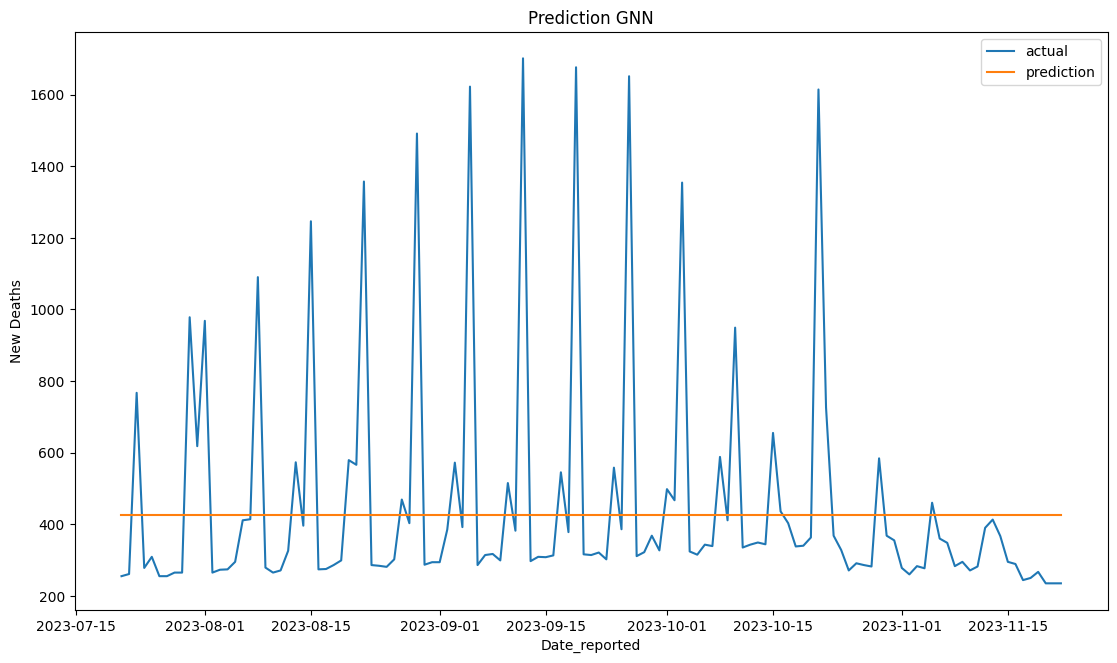

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(unique_dates[-len(pred):], y_true-1, label="actual")
ax.plot(unique_dates[-len(pred):], pred-1, label="prediction")
ax.set_title("Prediction GNN")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [150]:
print_evaluation_metrics(pred-1, y_true-1, np.sum(y_train, axis=1)-1)

Evaluation Metrics:
MSE: 114292.66
RMSE: 338.07
MAE: 201.96
MAPE: 39.51
SMAPE: 38.11
MASE: 0.11
